<a href="https://colab.research.google.com/github/dipstheoracle/dipstheoracle/blob/main/load_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# filename = 'ETH_USD_USD__15m_2025-02-20_to_2025-02-25_with_pivot_point.csv'
filename = 'ETH_USDT_15m_2025-01-01_to_2025-03-09_with_pivot_point.csv'

In [ ]:
df = pd.read_csv(filename)

In [ ]:
df['consolidated_pivot_zones'] = df['pivot_zones']
df['first_last_pivot_zones'] = df['pivot_zones']

In [ ]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'date',
       'daily_high', 'daily_low', 'daily_close', 'pp', 'r1', 'r2', 'r3', 's1',
       's2', 's3', 'touches_pp', 'crosses_up_pp', 'crosses_down_pp',
       'pivot_zones', 'touches_r1', 'crosses_up_r1', 'crosses_down_r1',
       'touches_r2', 'crosses_up_r2', 'crosses_down_r2', 'touches_r3',
       'crosses_up_r3', 'crosses_down_r3', 'touches_s1', 'crosses_up_s1',
       'crosses_down_s1', 'touches_s2', 'crosses_up_s2', 'crosses_down_s2',
       'touches_s3', 'crosses_up_s3', 'crosses_down_s3', 'diff_pp_r1',
       'diff_pp_r2', 'diff_pp_r3', 'diff_pp_s1', 'diff_pp_s2', 'diff_pp_s3',
       'diff_pp_s1 - diff_pp_r1', 'consolidated_pivot_zones',
       'first_last_pivot_zones'],
      dtype='object')

In [ ]:
def categorize_pivot_zones(zones_list):
    # Define the order of levels
    order = ["Below S3", "S3", "S2-S3", "S2", "S1-S2", "S1", "PP-S1", "PP", "PP-R1", "R1", "R1-R2", "R2", "R2-R3", "R3", "Above R3"]

    # Extract all individual levels from the given list
    levels = set()
    for multi_zone in zones_list:
        # print(zone)
        for zone in multi_zone.split(", "):
            # print(zone)
            try:
                left, right = zone.split("-")
                levels.add(left)
                levels.add(right)
            except:
                levels.add(zone)
                levels.add(zone)

    # Find the lowest and highest zones based on the order
    sorted_levels = sorted(levels, key=lambda x: order.index(x))
    return f"{sorted_levels[-1]} - {sorted_levels[0]}"

def split_and_remove_consecutive_duplicates(arr):
    """Splits elements containing multiple zones and removes consecutive duplicates."""
    expanded_list = []
    for item in arr:
        zones = item.split(', ')  # Split multiple zones
        expanded_list.extend(zones)  # Add them separately

    # Remove consecutive duplicates
    filtered_list = [expanded_list[i] for i in range(len(expanded_list)) if i == 0 or expanded_list[i] != expanded_list[i - 1]]

    return np.array(filtered_list)

# def reverse_zones(arr):
#     """Splits each zone at '-', reverses left and right, and removes consecutive duplicates."""
#     expanded_list = []
#     # print(type(arr))
#     if isinstance(arr, str):
#         arr = [arr]
#     for item in arr:
#         zones = item.split(', ')  # Split multiple zones if present
#         # print("zones", zones)
#         reversed_zones = ['-'.join(zone.split('-')[::-1]) for zone in zones]  # Reverse left-right
#         # print("reversed_zones", reversed_zones)
#         expanded_list.extend(reversed_zones)  # Add to list

#     # Remove consecutive duplicates
#     # filtered_list = [expanded_list[i] for i in range(len(expanded_list)) if i == 0 or expanded_list[i] != expanded_list[i - 1]]

#     return np.array(expanded_list)

def get_level_difference(zone):
    """Calculate the difference in level numbers."""
    parts = zone.split(" - ")  # Split range
    level_numbers = {"Below S3":-4, "S3":-3,  "S2":-2, "S1":-1, "PP":0, "R1":1, "R2":2, "R3":3, "Above R3":4}
    levels = [level_numbers[p] for p in parts]  # Convert to numeric levels
    return abs(levels[0] - levels[1])  # Compute absolute difference

def get_zone_difference(zones):
    level_numbers = {"Below S3":-4, "S3":-3,  "S2":-2, "S1":-1, "PP":0, "R1":1, "R2":2, "R3":3, "Above R3":4}
    left_part = zones[0].split("-")[0]
    left_part_level_number = level_numbers[left_part]
    right_part = zones[1].split("-")[0]
    right_part_level_number = level_numbers[right_part]
    action = None
    if left_part > right_part:
        action = 'Prices went Down'
    elif left_part < right_part:
        action = 'Prices went Up'
    else:
        action = 'Prices were Neutral'
    return action

# Function to get first and last pivot zones
def first_last_pivot_zones(arr):
    expanded_list = []
    for item in arr:
        zones = item.split(', ')  # Split multiple zones
        expanded_list.extend(zones)  # Add them separately
    unique_zones = expanded_list
    if len(unique_zones) >= 2:
        return [unique_zones[0], unique_zones[-1]]
    elif len(unique_zones) == 1:
        return [unique_zones[0]]  # Only one unique pivot zone
    else:
        return []  # Empty case


In [ ]:
# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Define aggregation rules for each column
aggregation_rules = {
    'diff_pp_r1': 'first',
    'diff_pp_r2': 'first',
    'diff_pp_r3': 'first',
    'diff_pp_s1': 'first',
    'diff_pp_s2': 'first',
    'diff_pp_s3': 'first',
    'diff_pp_s1 - diff_pp_r1': 'first',
}

# Apply OR operation for boolean columns
boolean_columns = [
    'touches_pp', 'crosses_up_pp', 'crosses_down_pp',
    'touches_r1', 'crosses_up_r1', 'crosses_down_r1',
    'touches_r2', 'crosses_up_r2', 'crosses_down_r2',
    'touches_r3', 'crosses_up_r3', 'crosses_down_r3',
    'touches_s1', 'crosses_up_s1', 'crosses_down_s1',
    'touches_s2', 'crosses_up_s2', 'crosses_down_s2',
    'touches_s3', 'crosses_up_s3', 'crosses_down_s3'
]

# Set OR aggregation for boolean columns
for col in boolean_columns:
    aggregation_rules[col] = 'any'  # OR operation

# **Handle `pivot_zones` column**
aggregation_rules['pivot_zones'] = lambda x: reverse_zones(split_and_remove_consecutive_duplicates(list(x)))  # Append unique values
aggregation_rules['consolidated_pivot_zones'] = lambda x: categorize_pivot_zones(list(x))  # Apply categorization
aggregation_rules['first_last_pivot_zones'] = lambda x: first_last_pivot_zones(list(x))  # Apply categorization

# Group by date and apply aggregation
grouped_df = df.groupby('date').agg(aggregation_rules)

# Display result
# print(grouped_df.head())

In [ ]:
# Apply function to calculate level difference
grouped_df["level_difference"] = grouped_df["consolidated_pivot_zones"].apply(get_level_difference)

In [ ]:
# grouped_df['first_last_pivot_zones'] = grouped_df['first_last_pivot_zones'].astype(str)

In [ ]:
# Apply function to calculate level difference
grouped_df["Summary"] = grouped_df["first_last_pivot_zones"].apply(get_zone_difference)

In [ ]:
grouped_df.head()

,diff_pp_r1,diff_pp_r2,diff_pp_r3,diff_pp_s1,diff_pp_s2,diff_pp_s3,diff_pp_s1 - diff_pp_r1,touches_pp,crosses_up_pp,crosses_down_pp,...,crosses_up_s2,crosses_down_s2,touches_s3,crosses_up_s3,crosses_down_s3,pivot_zones,consolidated_pivot_zones,first_last_pivot_zones,level_difference,Summary
date,,,,,,,,,,,,,,,,,,,,,
2025-01-02,23.3020,37.6980,61.00,23.3020,37.6980,61.00,0.0,False,False,False,...,False,False,False,False,False,"[PP-R1, R2-R3, R1-R2, PP-R1, R2-R3, R1-R2, R2-...",Above R3 - PP,"[R1-PP, Above R3]",4,Prices went Down
2025-01-03,59.8403,96.8097,156.65,59.8403,96.8097,156.65,0.0,True,True,True,...,False,False,False,False,False,"[PP-R1, S1-PP, PP-R1, S1-PP, PP-R1, S1-PP, PP-...",Above R3 - S1,"[R1-PP, Above R3]",5,Prices went Down
2025-01-04,79.3223,128.3277,207.65,79.3223,128.3277,207.65,0.0,False,False,False,...,False,False,False,False,False,"[PP-R1, R1-R2, PP-R1, R1-R2, PP-R1, R1-R2, PP-...",R2 - PP,"[R1-PP, R2-R1]",2,Prices went Up
2025-01-05,37.8371,61.2129,99.05,37.8371,61.2129,99.05,0.0,True,True,True,...,False,False,False,False,False,"[PP-R1, R1-R2, PP-R1, S1-PP, PP-R1, S1-PP, PP-...",R2 - S2,"[R1-PP, R1-PP]",4,Prices were Neutral
2025-01-06,31.4768,50.9232,82.40,31.4768,50.9232,82.40,0.0,True,True,True,...,False,False,False,False,False,"[PP-R1, S1-PP, PP-R1, S1-PP, PP-R1, S1-PP, PP-...",Above R3 - S1,"[R1-PP, R2-R1]",5,Prices went Up


In [ ]:
# Define the desired column order
column_order = [
    'pivot_zones', 'consolidated_pivot_zones', 'first_last_pivot_zones','Summary','level_difference',
    'diff_pp_r1', 'diff_pp_r2', 'diff_pp_r3',
    'diff_pp_s1', 'diff_pp_s2', 'diff_pp_s3',
    'diff_pp_s1 - diff_pp_r1'
] + boolean_columns  # Append boolean columns at the end

# Reorder grouped dataframe
grouped_df = grouped_df[column_order]

In [ ]:
# Convert diff_pp_* columns to integers
diff_columns = ['diff_pp_r1', 'diff_pp_r2', 'diff_pp_r3', 'diff_pp_s1', 'diff_pp_s2', 'diff_pp_s3']
grouped_df[diff_columns] = grouped_df[diff_columns].astype(int)

In [ ]:
grouped_df.head(5)

,pivot_zones,consolidated_pivot_zones,first_last_pivot_zones,Summary,level_difference,diff_pp_r1,diff_pp_r2,diff_pp_r3,diff_pp_s1,diff_pp_s2,...,crosses_down_r3,touches_s1,crosses_up_s1,crosses_down_s1,touches_s2,crosses_up_s2,crosses_down_s2,touches_s3,crosses_up_s3,crosses_down_s3
date,,,,,,,,,,,,,,,,,,,,,
2025-01-02,"[PP-R1, R2-R3, R1-R2, PP-R1, R2-R3, R1-R2, R2-...",Above R3 - PP,"[R1-PP, Above R3]",Prices went Down,4,23,37,61,23,37,...,True,False,False,False,False,False,False,False,False,False
2025-01-03,"[PP-R1, S1-PP, PP-R1, S1-PP, PP-R1, S1-PP, PP-...",Above R3 - S1,"[R1-PP, Above R3]",Prices went Down,5,59,96,156,59,96,...,False,False,False,False,False,False,False,False,False,False
2025-01-04,"[PP-R1, R1-R2, PP-R1, R1-R2, PP-R1, R1-R2, PP-...",R2 - PP,"[R1-PP, R2-R1]",Prices went Up,2,79,128,207,79,128,...,False,False,False,False,False,False,False,False,False,False
2025-01-05,"[PP-R1, R1-R2, PP-R1, S1-PP, PP-R1, S1-PP, PP-...",R2 - S2,"[R1-PP, R1-PP]",Prices were Neutral,4,37,61,99,37,61,...,False,True,False,False,False,False,False,False,False,False
2025-01-06,"[PP-R1, S1-PP, PP-R1, S1-PP, PP-R1, S1-PP, PP-...",Above R3 - S1,"[R1-PP, R2-R1]",Prices went Up,5,31,50,82,31,50,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
# # Convert each element inside the list to a plain string
# grouped_df['first_last_pivot_zones'] = grouped_df['first_last_pivot_zones'].apply(lambda x: [str(item) for item in x] if isinstance(x, list) else x)

# # Convert list to a properly formatted string (comma-separated)
# grouped_df['first_last_pivot_zones'] = grouped_df['first_last_pivot_zones'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [ ]:
grouped_df['pivot_zones'].iloc[0]

array(['PP-R1', 'R2-R3', 'R1-R2', 'PP-R1', 'R2-R3', 'R1-R2', 'R2-R3',
       'R1-R2', 'R2-R3', 'R1-R2', 'R2-R3', 'R1-R2', 'R2-R3', 'R1-R2',
       'R2-R3', 'R1-R2', 'R2-R3', 'R1-R2', 'R2-R3', 'Above R3', 'R2-R3',
       'Above R3', 'R2-R3', 'Above R3'], dtype='<U8')

In [ ]:
grouped_df.to_csv(f"{filename}_group_by_date_new.csv")

In [ ]:
# df.iloc[:,-7:] = round(df.iloc[:,-7:])

In [ ]:
# df['diff_pp_r1'] = round(df['diff_pp_r1'])

In [ ]:
df.iloc[:,-30:-18]

,s3,touches_pp,crosses_up_pp,crosses_down_pp,pivot_zones,touches_r1,crosses_up_r1,crosses_down_r1,touches_r2,crosses_up_r2,crosses_down_r2,touches_r3
0,2237.133333,False,False,False,"R1-R2, PP-R1",True,True,False,False,False,False,False
1,2237.133333,False,False,False,"R2-R3, R1-R2, PP-R1",True,False,False,True,False,False,False
2,2237.133333,False,False,False,"R2-R3, R1-R2",False,False,False,True,True,False,False
3,2237.133333,False,False,False,R2-R3,False,False,False,False,False,False,False
4,2237.133333,False,False,False,R2-R3,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
39750,2525.196667,False,False,False,S1-PP,False,False,False,False,False,False,False
39751,2525.196667,False,False,False,S1-PP,False,False,False,False,False,False,False
39752,2525.196667,True,True,False,"PP-R1, S1-PP",False,False,False,False,False,False,False
39753,2525.196667,True,False,False,"PP-R1, S1-PP",False,False,False,False,False,False,False


In [ ]:
df[df['date'] == '2025-02-10']['pivot_zones']

array(['PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1, S1-PP',
       'PP-R1, S1-PP', 'S1-PP', 'S1-PP', 'S1-PP', 'S1-PP', 'S1-PP',
       'S1-PP', 'PP-R1, S1-PP', 'PP-R1, S1-PP', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP-R1', 'PP-R1', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1',
       'R1-R2, PP-R1', 'R1-R2, PP-R1', 'R1-R2, PP-R1', 'PP-R1',
       'R1-R2, PP-R1', 'R1-R2', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'R1-R2, PP-R1', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
       'PP-R1', 'PP

In [ ]:
# Example array
zones_array = np.array([
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1, S1-PP',
    'PP-R1, S1-PP', 'S1-PP', 'S1-PP', 'S1-PP', 'S1-PP', 'S1-PP',
    'S1-PP', 'PP-R1, S1-PP', 'PP-R1, S1-PP', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1',
    'R1-R2, PP-R1', 'R1-R2, PP-R1', 'R1-R2, PP-R1', 'PP-R1',
    'R1-R2, PP-R1', 'R1-R2', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'R1-R2, PP-R1', 'R1-R2, PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1', 'PP-R1',
    'PP-R1'
])

# Apply function
filtered_zones = split_and_remove_consecutive_duplicates(zones_array)
print(filtered_zones)

['PP-R1' 'S1-PP' 'PP-R1' 'S1-PP' 'PP-R1' 'S1-PP' 'PP-R1' 'S1-PP' 'PP-R1'
 'R1-R2' 'PP-R1' 'R1-R2' 'PP-R1' 'R1-R2' 'PP-R1' 'R1-R2' 'PP-R1' 'R1-R2'
 'PP-R1' 'R1-R2' 'PP-R1' 'R1-R2' 'PP-R1' 'R1-R2' 'PP-R1' 'R1-R2' 'PP-R1']


In [ ]:
filtered_zones

array(['PP-R1', 'S1-PP', 'PP-R1', 'S1-PP', 'PP-R1', 'S1-PP', 'PP-R1',
       'S1-PP', 'PP-R1', 'R1-R2', 'PP-R1', 'R1-R2', 'PP-R1', 'R1-R2',
       'PP-R1', 'R1-R2', 'PP-R1', 'R1-R2', 'PP-R1', 'R1-R2', 'PP-R1',
       'R1-R2', 'PP-R1', 'R1-R2', 'PP-R1', 'R1-R2', 'PP-R1'], dtype='<U5')

In [ ]:
reverse_zones(filtered_zones)

array(['R1-PP', 'PP-S1', 'R1-PP', 'PP-S1', 'R1-PP', 'PP-S1', 'R1-PP',
       'PP-S1', 'R1-PP', 'R2-R1', 'R1-PP', 'R2-R1', 'R1-PP', 'R2-R1',
       'R1-PP', 'R2-R1', 'R1-PP', 'R2-R1', 'R1-PP', 'R2-R1', 'R1-PP',
       'R2-R1', 'R1-PP', 'R2-R1', 'R1-PP', 'R2-R1', 'R1-PP'], dtype='<U5')

In [ ]:
diff_pp_r1 = df['diff_pp_r1']
unique_diff_pp_r1 = diff_pp_r1.unique()

In [ ]:
len(unique_diff_pp_r1)

414

In [ ]:
# Compute min, max, and 25th percentile
min_val = float(round(np.min(unique_diff_pp_r1),2))
max_val = float(round(np.max(unique_diff_pp_r1),2))
percentile_25 = float(round(np.percentile(unique_diff_pp_r1, 25),2))
percentile_50 = float(round(np.percentile(unique_diff_pp_r1, 50),2))
percentile_75 = float(round(np.percentile(unique_diff_pp_r1, 75),2))

min_val, max_val, percentile_25, percentile_50, percentile_75

(12.11, 320.56, 36.58, 52.11, 74.53)

In [ ]:
number_of_bins = 15
bin_size = float(round(((max_val - min_val)/number_of_bins),2))
bin_size

20.56

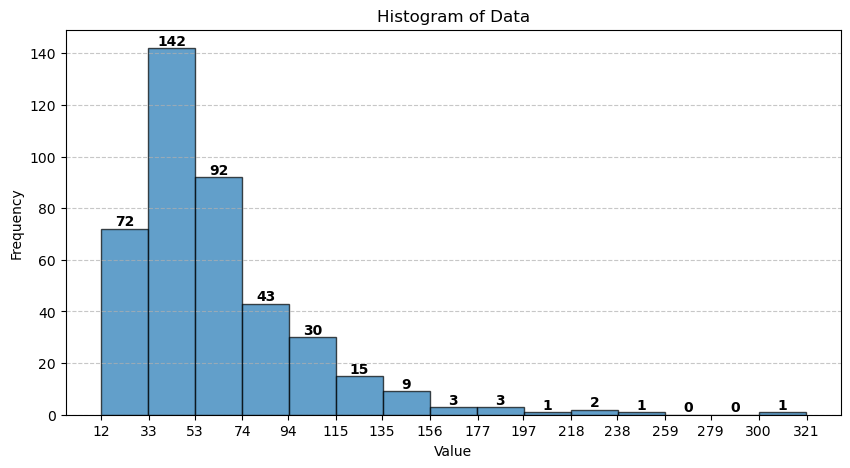

In [ ]:
# Create histogram
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(unique_diff_pp_r1, bins=number_of_bins, edgecolor='black', alpha=0.7)

# Annotate each bin with its count
for count, bin_patch in zip(counts, patches):
    plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count,
             str(int(count)), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Round x-axis bin labels to no decimal places
rounded_bins = [int(round(b)) for b in bins]  # Round bin edges
plt.xticks(rounded_bins)  # Set new x-tick labels

# Labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

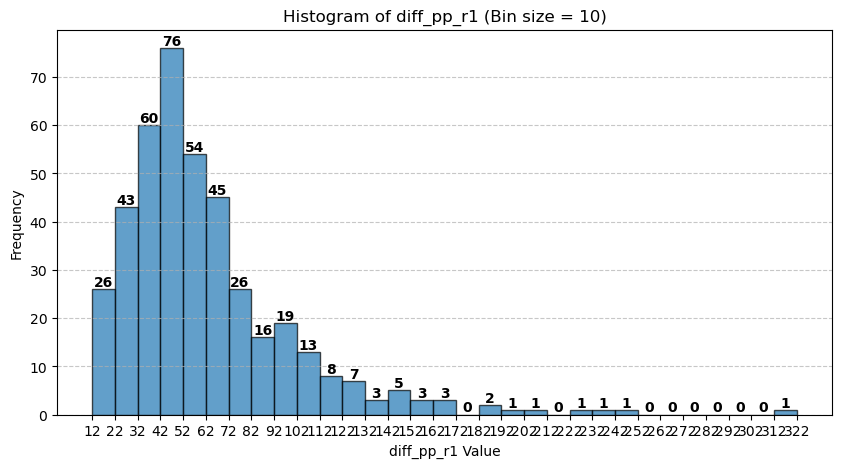

            Min  Max      Mean  Mode
diff_pp_r1                          
(12, 22]    3.0  7.0  5.038462   5.0
(22, 32]    2.0  7.0  4.697674   4.0
(32, 42]    2.0  7.0  4.233333   4.0
(42, 52]    1.0  7.0  3.894737   4.0
(52, 62]    2.0  7.0  3.907407   4.0
(62, 72]    2.0  7.0  3.422222   4.0
(72, 82]    2.0  5.0  3.423077   4.0
(82, 92]    2.0  6.0  3.500000   4.0
(92, 102]   2.0  5.0  2.842105   2.0
(102, 112]  2.0  5.0  3.461538   3.0
(112, 122]  1.0  3.0  2.125000   2.0
(122, 132]  2.0  4.0  3.285714   3.0
(132, 142]  3.0  3.0  3.000000   3.0
(142, 152]  2.0  4.0  3.000000   2.0
(152, 162]  2.0  5.0  3.333333   2.0
(162, 172]  2.0  4.0  2.666667   2.0
(172, 182]  NaN  NaN       NaN   NaN
(182, 192]  2.0  4.0  3.000000   2.0
(192, 202]  2.0  2.0  2.000000   2.0
(202, 212]  3.0  3.0  3.000000   3.0
(212, 222]  NaN  NaN       NaN   NaN
(222, 232]  1.0  1.0  1.000000   1.0
(232, 242]  3.0  3.0  3.000000   3.0
(242, 252]  2.0  2.0  2.000000   2.0
(252, 262]  NaN  NaN       NaN   NaN
(

C:\Users\Admin\AppData\Local\Temp\ipykernel_15596\2528505150.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = grouped_df.groupby(pd.cut(grouped_df['diff_pp_r1'], bins=bin_edges))['level_difference'].agg(['min', 'max', 'mean', safe_mode])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15596\2528505150.py:30: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  m = mode(x, keepdims=True)


In [ ]:
from scipy.stats import mode

# Example: Extract diff_pp_r1 values from grouped_df
diff_pp_r1_values = grouped_df['diff_pp_r1'].dropna()

# Define bin edges with step size of 10
min_val = int(diff_pp_r1_values.min())
max_val = int(diff_pp_r1_values.max())
bin_edges = np.arange(min_val, max_val + 10, 10)

# Create histogram
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(diff_pp_r1_values, bins=bin_edges, edgecolor='black', alpha=0.7)

# Annotate each bin with its count
for count, bin_patch in zip(counts, patches):
    plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count,
             str(int(count)), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Set x-axis bin labels
plt.xticks(bin_edges)
plt.xlabel('diff_pp_r1 Value')
plt.ylabel('Frequency')
plt.title('Histogram of diff_pp_r1 (Bin size = 10)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute statistics for level_difference per 10-unit interval
def safe_mode(x):
    m = mode(x, keepdims=True)
    return m.mode[0] if m.count.size > 0 else np.nan  # Handle empty cases

grouped_stats = grouped_df.groupby(pd.cut(grouped_df['diff_pp_r1'], bins=bin_edges))['level_difference'].agg(['min', 'max', 'mean', safe_mode])
grouped_stats.columns = ['Min', 'Max', 'Mean', 'Mode']

# Display results
print(grouped_stats)


In [ ]:
pip install scipy


   ---------------------------------------- 0.0/40.9 MB ? eta -:--:--
   ---- ----------------------------------- 4.5/40.9 MB 24.4 MB/s eta 0:00:02
   -------- ------------------------------- 8.4/40.9 MB 21.7 MB/s eta 0:00:02
   ------------ --------------------------- 12.3/40.9 MB 20.3 MB/s eta 0:00:02
   ---------------- ----------------------- 17.3/40.9 MB 21.4 MB/s eta 0:00:02
   --------------------- ------------------ 21.8/40.9 MB 21.2 MB/s eta 0:00:01
   ------------------------ --------------- 24.6/40.9 MB 20.5 MB/s eta 0:00:01
   --------------------------- ------------ 28.0/40.9 MB 19.5 MB/s eta 0:00:01
   ------------------------------ --------- 30.9/40.9 MB 19.1 MB/s eta 0:00:01
   ---------------------------------- ----- 35.1/40.9 MB 18.9 MB/s eta 0:00:01
   ------------------------------------- -- 38.8/40.9 MB 18.7 MB/s eta 0:00:01
   ---------------------------------------  40.9/40.9 MB 18.3 MB/s eta 0:00:01
   ---------------------------------------- 40.9/40.9 MB 17.7 

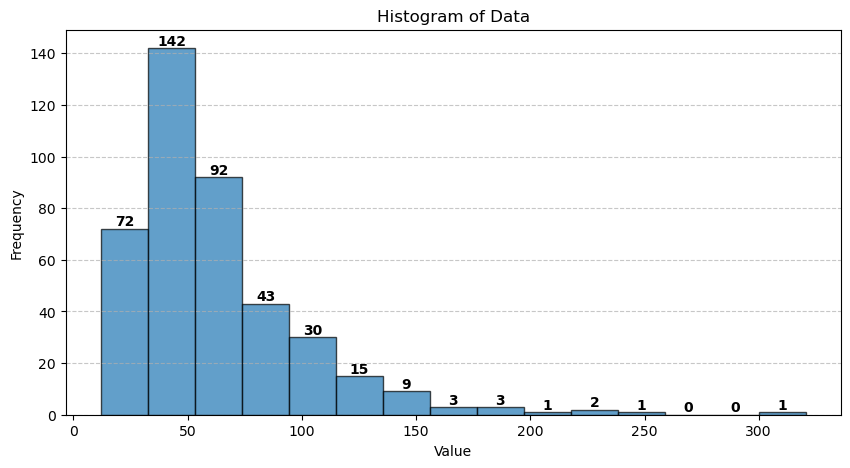

In [ ]:
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(unique_diff_pp_r1, bins=number_of_bins, edgecolor='black', alpha=0.7)

# Annotate each bin with its count
for count, bin_patch in zip(counts, patches):
    plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count,
             str(int(count)), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

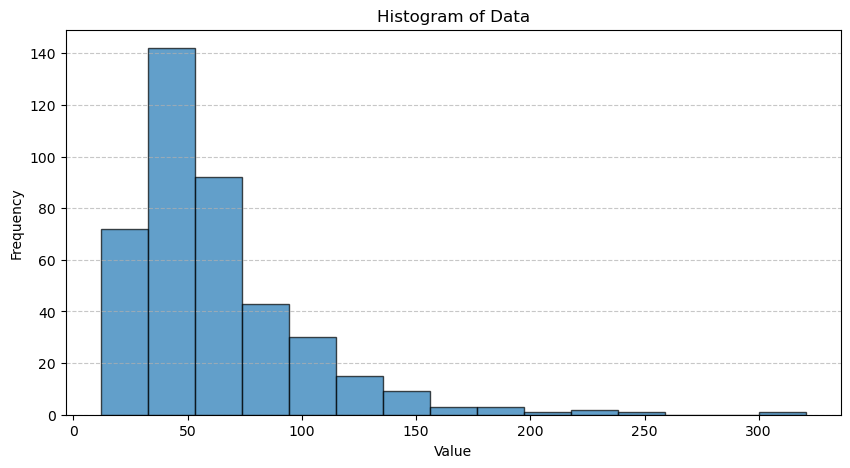

In [ ]:
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(unique_diff_pp_r1, bins=number_of_bins, edgecolor='black', alpha=0.7)  # 15 bins
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
unique_diff_pp_r1

array([ 33.72296,  38.00518, 122.36224,  35.6979 ,  27.56512,  20.92596,
        21.74344,  74.1844 ,  59.17944, 118.17934,  48.21222,  99.89682,
        35.717  ,  41.68766,  31.69072,  43.4716 ,  33.3295 ,  46.51614,
        34.23102,  14.77194,  12.1094 ,  62.7435 ,  70.38732,  26.52608,
        28.08082,  33.16142,  12.61364,  27.29008,  34.58246,  37.33668,
        34.1317 ,  28.46282,  17.1327 ,  15.0699 ,  18.90518,  26.88516,
        36.00732,  35.50308,  20.29184,  42.1728 ,  17.60256,  17.96928,
        75.51758,  39.3842 ,  64.84832,  42.94062,  48.56366,  33.51668,
        51.2644 ,  50.35524,  62.35386,  58.11366,  52.27288,  34.14316,
        39.01366,  55.68414,  62.1705 ,  48.62096, 133.36766,  88.09302,
        43.47924,  32.47   ,  53.8238 ,  85.7781 , 237.95926, 154.87044,
        77.37792,  67.7095 ,  28.42844,  68.6263 , 143.69312, 101.87558,
        59.8403 , 110.94044, 142.16512, 120.72346, 102.46386,  74.13092,
       152.41418, 184.94912,  67.41154, 112.78932, 